In [1]:
# cBioPortal_TCGA_GeneExprMutation.v01
# Alberto Bejarano (2024)
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

June 09, 2024 15:40:07


In [2]:
# https://pybioportal.readthedocs.io/en/latest/index.html
# https://github.com/Matteo-Valerio/pyBioPortal/tree/master/examples
# https://github.com/LLCampos/pybioportal
# https://pypi.org/project/pybioportal/
# https://www.biostars.org/p/106127/
# https://docs.cbioportal.org/user-guide/faq/#what-are-mrna-and-microrna-z-scores
# https://www.ebi.ac.uk/gxa/FAQ.html

In [3]:
#!pip install pybioportal
#!conda install -c matteo.valerio pybioportal
#!pip install autograd

In [4]:
#%config InlineBackend.figure_format = "retina"
#%matplotlib inline

In [5]:
from pybioportal import server_running_status as srs
from pybioportal import molecular_profiles as mf
from pybioportal import molecular_data as md
from pybioportal import mutations as mts
from pybioportal import samples as sp
#          -          -          -          -          -          -          -          -          -          -          -  
import pandas as pd
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.3f}'.format
#        -         -        -        -         -        -         -        -        -         -
import warnings; warnings.filterwarnings("ignore")
#from scipy.stats import mannwhitneyu, normaltest
#from statannotations.Annotator import Annotator
#from statannot import add_stat_annotation
import matplotlib.pyplot as plt
import matplotlib.transforms
import autograd.numpy as np
import seaborn as sns

In [6]:
srs.get_server_status()

,status
0,UP


In [7]:
GenesOfInterest = ["PDCD1", "CD274", "CTLA4"]
GenesOfInterest = ["5133", "29126", "1493"]
GenesOfInterest = ["PDCD1", "CD274", "CTLA4"]
GenesOfInterest = ['EGFR', 'ERBB2', 'PTEN', 'CCND1', 'TP53', 'CDKN1B', 'KRAS', 'NRAS', 'HRAS', 'BRAF', 'PIK3CA', 'TTN']

GenesOfInterest = ['TP53']

In [8]:
genes_df = pd.read_csv("./metadata/HGNC_table.txt", header=0, sep='\t', quotechar='"', on_bad_lines="warn")
genes_df = genes_df.dropna(subset=['NCBI Gene ID'])
genes_df["NCBI Gene ID"] = genes_df["NCBI Gene ID"].astype(int)
genes_df = genes_df[genes_df["Approved symbol"].isin(GenesOfInterest)]
genes_df = genes_df[['Approved symbol', 'NCBI Gene ID']].copy()
genes_df.rename({'NCBI Gene ID':'entrezGeneId', 'Approved symbol':'ApprovedSymbol'},axis=1,inplace=True)
genes_df.sample()

,ApprovedSymbol,entrezGeneId
44410,TP53,7157


In [9]:
genes = sorted(genes_df['ApprovedSymbol'].astype(str).unique().tolist()); print(genes)

['TP53']


In [10]:
NCBIgenes = sorted(genes_df['entrezGeneId'].astype(str).unique().tolist()); print(NCBIgenes)

['7157']


In [11]:
df = mf.get_all_molecular_profiles()
df.sample(3)

,molecularAlterationType,datatype,name,description,showProfileInAnalysisTab,patientLevel,molecularProfileId,studyId,genericAssayType,pivotThreshold,sortOrder
620,COPY_NUMBER_ALTERATION,DISCRETE,Copy Number Alterations,Copy-number from MSK-IMPACT and FACETS. Values...,True,False,paired_bladder_2022_cna,paired_bladder_2022,NaN,NaN,NaN
757,STRUCTURAL_VARIANT,SV,Structural variants,Structural Variant Data.,True,False,thyroid_mskcc_2016_structural_variants,thyroid_mskcc_2016,NaN,NaN,NaN
1536,PROTEIN_LEVEL,Z-SCORE,Protein expression z-scores (RPPA),"Protein expression, measured by reverse-phase ...",True,False,kich_tcga_pan_can_atlas_2018_rppa_Zscores,kich_tcga_pan_can_atlas_2018,NaN,NaN,NaN


In [12]:
molecular_profiles00 = df.molecularProfileId.unique().tolist(); 
molecular_profiles00 = [item for item in molecular_profiles00 if '_tcga_' in item]
print('\033[33m', sorted(molecular_profiles00[:100]), '\033[0m')

 ['blca_tcga_pub_gistic', 'blca_tcga_pub_linear_CNA', 'blca_tcga_pub_methylation_hm450', 'blca_tcga_pub_mutations', 'blca_tcga_pub_rna_seq_mrna_median_Zscores', 'blca_tcga_pub_rna_seq_v2_mrna', 'blca_tcga_pub_rna_seq_v2_mrna_median_all_sample_Zscores', 'blca_tcga_pub_rppa', 'blca_tcga_pub_rppa_Zscores', 'blca_tcga_pub_structural_variants', 'brca_tcga_pub_gistic', 'brca_tcga_pub_linear_CNA', 'brca_tcga_pub_methylation_hm27', 'brca_tcga_pub_mirna', 'brca_tcga_pub_mirna_median_Zscores', 'brca_tcga_pub_mrna', 'brca_tcga_pub_mrna_median_Zscores', 'brca_tcga_pub_mrna_median_all_sample_Zscores', 'brca_tcga_pub_mrna_merged_median_Zscores', 'brca_tcga_pub_mutations', 'brca_tcga_pub_rppa', 'brca_tcga_pub_rppa_Zscores', 'coadread_tcga_gistic', 'coadread_tcga_linear_CNA', 'coadread_tcga_methylation_hm450', 'coadread_tcga_mrna', 'coadread_tcga_mrna_median_Zscores', 'coadread_tcga_mrna_median_all_sample_Zscores', 'coadread_tcga_mutations', 'coadread_tcga_protein_quantification', 'coadread_tcga_prote

In [13]:
molPrfile_01 = "_tcga_rna_seq_v2_mrna"
filterout_01 = ["_median_Zscores", "_median_all_sample_Zscores", "_gistic", "_linear_CNA", "_mutations", "_methylation_hm450", "_pan_can_atlas_",
             "rppa", "log2CNA", "structural_variants", "protein_quantification", "U133", "methylation_hm27", "tcga_mrna",
            ]

In [14]:
molPrfile_02 = ['_tcga_mutations'] # '_mutations', '_tcga_', 

In [15]:
df_exp = df[~df['molecularProfileId'].str.contains('|'.join(filterout_01))]
df_exp = df_exp[df_exp['molecularProfileId'].str.contains(molPrfile_01)]
#          -          -          -          -          -          -          -          -          -          -          - 
condition = df['molecularProfileId'].str.contains(molPrfile_02[0])
for substring in molPrfile_02[1:]:
    condition = condition & df['molecularProfileId'].str.contains(substring)
df_mut = df[condition]

In [16]:
molecular_profiles01 = df_exp.molecularProfileId.unique().tolist()
print(len(molecular_profiles01)); print('\033[33m', sorted(molecular_profiles01), '\033[0m')

32
 ['acc_tcga_rna_seq_v2_mrna', 'blca_tcga_rna_seq_v2_mrna', 'brca_tcga_rna_seq_v2_mrna', 'cesc_tcga_rna_seq_v2_mrna', 'chol_tcga_rna_seq_v2_mrna', 'coadread_tcga_rna_seq_v2_mrna', 'dlbc_tcga_rna_seq_v2_mrna', 'esca_tcga_rna_seq_v2_mrna', 'gbm_tcga_rna_seq_v2_mrna', 'hnsc_tcga_rna_seq_v2_mrna', 'kich_tcga_rna_seq_v2_mrna', 'kirc_tcga_rna_seq_v2_mrna', 'kirp_tcga_rna_seq_v2_mrna', 'laml_tcga_rna_seq_v2_mrna', 'lgg_tcga_rna_seq_v2_mrna', 'lihc_tcga_rna_seq_v2_mrna', 'luad_tcga_rna_seq_v2_mrna', 'lusc_tcga_rna_seq_v2_mrna', 'meso_tcga_rna_seq_v2_mrna', 'ov_tcga_rna_seq_v2_mrna', 'paad_tcga_rna_seq_v2_mrna', 'pcpg_tcga_rna_seq_v2_mrna', 'prad_tcga_rna_seq_v2_mrna', 'sarc_tcga_rna_seq_v2_mrna', 'skcm_tcga_rna_seq_v2_mrna', 'stad_tcga_rna_seq_v2_mrna', 'tgct_tcga_rna_seq_v2_mrna', 'thca_tcga_rna_seq_v2_mrna', 'thym_tcga_rna_seq_v2_mrna', 'ucec_tcga_rna_seq_v2_mrna', 'ucs_tcga_rna_seq_v2_mrna', 'uvm_tcga_rna_seq_v2_mrna'] 


In [17]:
molecular_profiles02 = df_mut.molecularProfileId.unique().tolist()
print(len(molecular_profiles02)); print('\033[33m', sorted(molecular_profiles02), '\033[0m')

32
 ['acc_tcga_mutations', 'blca_tcga_mutations', 'brca_tcga_mutations', 'cesc_tcga_mutations', 'chol_tcga_mutations', 'coadread_tcga_mutations', 'dlbc_tcga_mutations', 'esca_tcga_mutations', 'gbm_tcga_mutations', 'hnsc_tcga_mutations', 'kich_tcga_mutations', 'kirc_tcga_mutations', 'kirp_tcga_mutations', 'laml_tcga_mutations', 'lgg_tcga_mutations', 'lihc_tcga_mutations', 'luad_tcga_mutations', 'lusc_tcga_mutations', 'meso_tcga_mutations', 'ov_tcga_mutations', 'paad_tcga_mutations', 'pcpg_tcga_mutations', 'prad_tcga_mutations', 'sarc_tcga_mutations', 'skcm_tcga_mutations', 'stad_tcga_mutations', 'tgct_tcga_mutations', 'thca_tcga_mutations', 'thym_tcga_mutations', 'ucec_tcga_mutations', 'ucs_tcga_mutations', 'uvm_tcga_mutations'] 


In [18]:
#molecular_profiles02 = ['acc_tcga_mutations']

In [19]:
%%time
exp_data = md.fetch_molecular_data(entrez_gene_ids=NCBIgenes, molecular_profile_ids=molecular_profiles01)
exp_data = exp_data[['sampleId', 'entrezGeneId', 'studyId', 'value']].copy()
print('\033[31m', len(exp_data), '\033[0m')
exp_data.sample(3)

 9721 
CPU times: total: 1.62 s
Wall time: 2.62 s


,sampleId,entrezGeneId,studyId,value
5391,TCGA-50-5930-01,7157,luad_tcga,1568.429
8069,TCGA-DX-A6YQ-01,7157,sarc_tcga,591.440
8743,TCGA-XE-AAO6-01,7157,tgct_tcga,1124.324


In [20]:
%%time
mut_data = mts.fetch_muts_in_multiple_mol_profs(entrez_gene_ids=NCBIgenes, molecular_profile_ids=molecular_profiles02)
mutationTypes = mut_data.mutationType.unique().tolist(); print('\033[33m', mutationTypes, '\033[0m')
mut_data = mut_data[['sampleId', 'entrezGeneId', 'studyId', 'mutationType']].copy()
print('\033[31m', len(mut_data), '\033[0m')
mut_data.sample(5)

 ['Nonsense_Mutation', 'Missense_Mutation', 'Splice_Site', 'Frame_Shift_Del', 'In_Frame_Del', 'Splice_Region', 'Frame_Shift_Ins', 'In_Frame_Ins', 'Translation_Start_Site'] 
 2878 
CPU times: total: 969 ms
Wall time: 1.72 s


,sampleId,entrezGeneId,studyId,mutationType
904,TCGA-13-0804-01,7157,ov_tcga,Missense_Mutation
2419,TCGA-VR-A8EZ-01,7157,esca_tcga,Missense_Mutation
279,TCGA-AG-3575-01,7157,coadread_tcga,Missense_Mutation
1399,TCGA-46-3767-01,7157,lusc_tcga,Missense_Mutation
2305,TCGA-LN-A8I0-01,7157,esca_tcga,Missense_Mutation


In [21]:
#mutationStatuss = mut_data.mutationStatus.unique().tolist(); print('\033[33m', sorted(mutationStatuss), '\033[0m')

In [22]:
data = pd.merge(exp_data, mut_data, on=['studyId', 'sampleId', 'entrezGeneId'], how='left')
data = pd.merge(data, genes_df, on='entrezGeneId', how='inner')

In [23]:
sampl_data = sp.fetch_samples(sample_list_ids=molecular_profiles01)
sampl_data = sampl_data[['sampleId', 'sampleType']].copy()
print('\033[31m', len(sampl_data), '\033[0m')
sampl_data.sample()

 9721 


,sampleId,sampleType
737,TCGA-RP-A693-06,Metastatic


In [24]:
data = pd.merge(data, sampl_data, on='sampleId', how='left')
data = data[['sampleId', 'studyId', 'sampleType', 'ApprovedSymbol', 'mutationType', 'value']].copy()
data['studyId'] = data['studyId'].str.replace('_tcga', '')

In [25]:
data.fillna('No_Mutation', inplace=True)
mutationTypes = data.mutationType.unique().tolist(); print('\033[33m', mutationTypes, '\033[0m')

 ['No_Mutation', 'Missense_Mutation', 'Frame_Shift_Ins', 'Frame_Shift_Del', 'Nonsense_Mutation', 'In_Frame_Del', 'Splice_Region', 'Splice_Site', 'In_Frame_Ins', 'Translation_Start_Site'] 


In [26]:
data.sampleType.value_counts(dropna=False)

sampleType
Primary Solid Tumor      9344
Metastatic                401
Primary Blood Tumor       175
Recurrent Solid Tumor      41
Name: count, dtype: int64

In [27]:
data.mutationType.value_counts(dropna=False)

mutationType
No_Mutation               7469
Missense_Mutation         1587
Nonsense_Mutation          326
Frame_Shift_Del            235
Splice_Site                184
Frame_Shift_Ins             81
In_Frame_Del                43
Splice_Region               27
In_Frame_Ins                 8
Translation_Start_Site       1
Name: count, dtype: int64

In [28]:
impact_mapping = {
    'No_Mutation':            'No_impact',
#          -          -          -          -          -    
    'Translation_Start_Site': 'Severe',  
    'Nonsense_Mutation':      'Severe',
    'Frame_Shift_Del':        'Severe',
    'Frame_Shift_Ins':        'Severe',
#          -          -          -          -          -   
    'Missense_Mutation':      'Moderate',
    'Splice_Region':          'Moderate',
    'Splice_Site':            'Moderate',
#          -          -          -          -          -     
    'In_Frame_Del':           'Mild',
    'In_Frame_Ins':           'Mild',
#          -          -          -          -          -    
}

data['impact'] = data['mutationType'].map(impact_mapping)

In [29]:
impactTypes = data.impact.unique().tolist(); print('\033[33m', impactTypes, '\033[0m')

 ['No_impact', 'Moderate', 'Severe', 'Mild'] 


In [30]:
sampleTypes = data.sampleType.unique().tolist(); print('\033[33m', sampleTypes, '\033[0m')

 ['Primary Solid Tumor', 'Recurrent Solid Tumor', 'Metastatic', 'Primary Blood Tumor'] 


In [31]:
data_df2 = data[["ApprovedSymbol", "studyId", "impact"]].copy()
count_df01 = data_df2.groupby(["ApprovedSymbol", "studyId", "impact"])["impact"].count().reset_index(name="IMPACT_count")
count_df01.sort_values(['ApprovedSymbol', 'studyId', 'impact'], ascending=[True, True, True], inplace=True)
count_df01.head(10)

,ApprovedSymbol,studyId,impact,IMPACT_count
0,TP53,acc,Mild,1
1,TP53,acc,Moderate,9
2,TP53,acc,No_impact,63
3,TP53,acc,Severe,7
4,TP53,blca,Moderate,57
5,TP53,blca,No_impact,344
6,TP53,blca,Severe,18
7,TP53,brca,Mild,5
8,TP53,brca,Moderate,199
9,TP53,brca,No_impact,800


test     Severe  Moderate  Mild  No_impact
studyId                                   
acc       0.087     0.113 0.013      0.787
blca      0.043     0.136 0.000      0.821
brca      0.090     0.180 0.005      0.725
cesc      0.003     0.036 0.000      0.961
chol      0.054     0.108 0.000      0.838


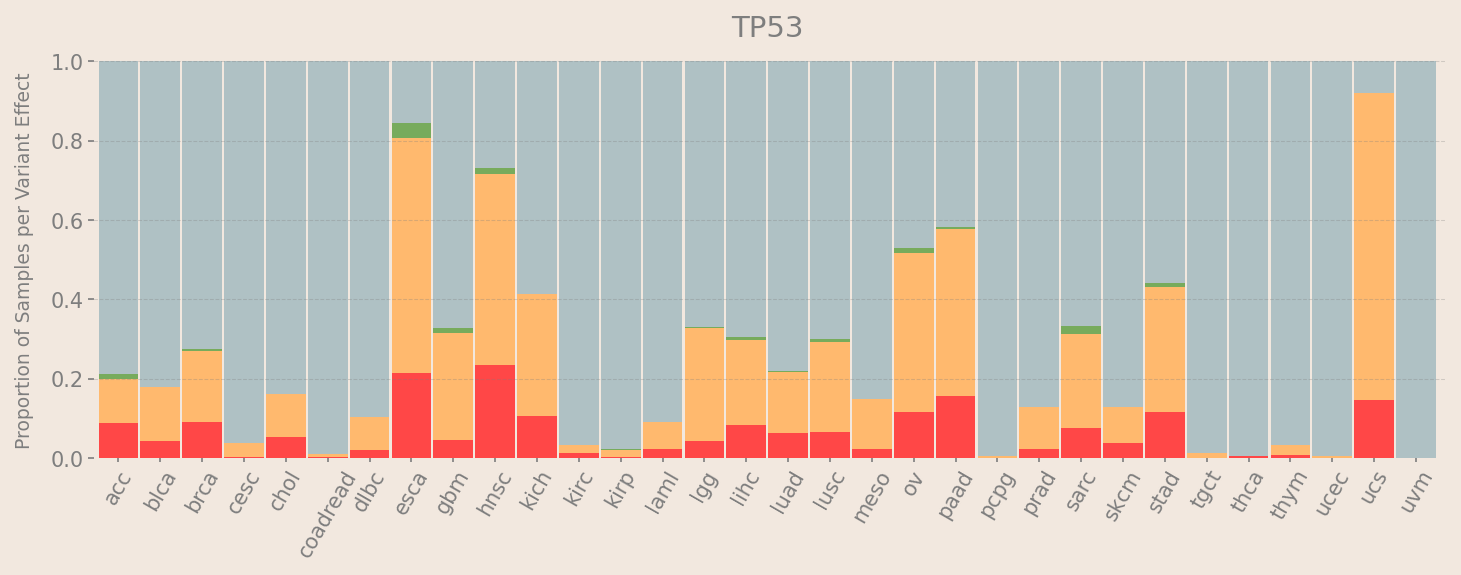

In [32]:
for gene in GenesOfInterest:
    fig, ax  = plt.subplots(figsize=(25/2.54, 10/2.54), dpi=150)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    df01 = data.loc[data.ApprovedSymbol == gene]; n=len(df01)
    df02 = df01[["studyId", "impact"]].copy(); #print(df02.head())
    norm_df = pd.crosstab(df02.studyId, df02.impact, normalize="index").rename_axis("test", axis=1)
    norm_df = norm_df[["No_impact", "Mild", "Moderate", "Severe"]].copy(); #print(df02.head())
    norm_df = norm_df[["Severe", "Moderate", "Mild", "No_impact"]].copy(); print(norm_df.head())
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#859da1', '#77ab5c', '#ffb96e', '#ff4747'])
    norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#ff4747', '#ffb96e', '#77ab5c', '#afc1c4'])
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    ax.set_title(gene, fontsize=14, color="#7E7E7E", pad=10)
    plt.xlabel("", fontsize=0); plt.ylabel("Proportion of Samples per Variant Effect", fontsize=9, color="#7E7E7E", labelpad=8)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -    
    ax.set_ylim(-.01, 1.01); ax.set_yscale('linear'); sns.despine(left=True, bottom=True)   
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -        
    plt.xticks(fontsize=10, color="#7E7E7E", rotation=60, ha="center")
    ax.tick_params(axis='x', which='major', direction='in', colors="#7E7E7E", pad=2, length=2)
    plt.yticks(fontsize=10, color="#7E7E7E", rotation=0, ha="center")
    ax.tick_params(axis='y', which='major', direction='in', colors="#7E7E7E", pad=10, length=3)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    kws_lines = {"ls":"--", 'color':'#7E7E7E', "alpha":0.3, "linewidth":.5}
    plt.axhline(y=0.2, **kws_lines); plt.axhline(y=0.4, **kws_lines);plt.axhline(y=0.6, **kws_lines);
    plt.axhline(y=0.8, **kws_lines); plt.axhline(y=1.0, **kws_lines);
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -   
    ax.set_facecolor('#f2e8df'); fig.patch.set_facecolor('#f2e8df')
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    plt.tight_layout(); #plt.show(); #plt.close()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:2],labels[0:2],fontsize=6,bbox_to_anchor=(1.02,1),loc=2,borderaxespad=0.1)
    plt.legend([],[],frameon=False)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -       
    #plt.savefig("tcga.png", format="png", bbox_inches="tight", dpi=300)

In [33]:
data.sample()

,sampleId,studyId,sampleType,ApprovedSymbol,mutationType,value,impact
3803,TCGA-CN-5361-01,hnsc,Primary Solid Tumor,TP53,No_Mutation,470.459,No_impact


impact   Mild  Moderate  No_impact  Severe  Moderate_Severe_sum
studyId                                                        
ucs     0.000     0.774      0.081   0.145                0.919
esca    0.038     0.592      0.156   0.213                0.806
hnsc    0.017     0.482      0.268   0.233                0.715
paad    0.006     0.422      0.417   0.156                0.578
ov      0.013     0.399      0.471   0.117                0.516
impact   Mild  Moderate  No_impact  Severe
studyId                                   
ucs     0.000     0.774      0.081   0.145
esca    0.038     0.592      0.156   0.213
hnsc    0.017     0.482      0.268   0.233
paad    0.006     0.422      0.417   0.156
ov      0.013     0.399      0.471   0.117


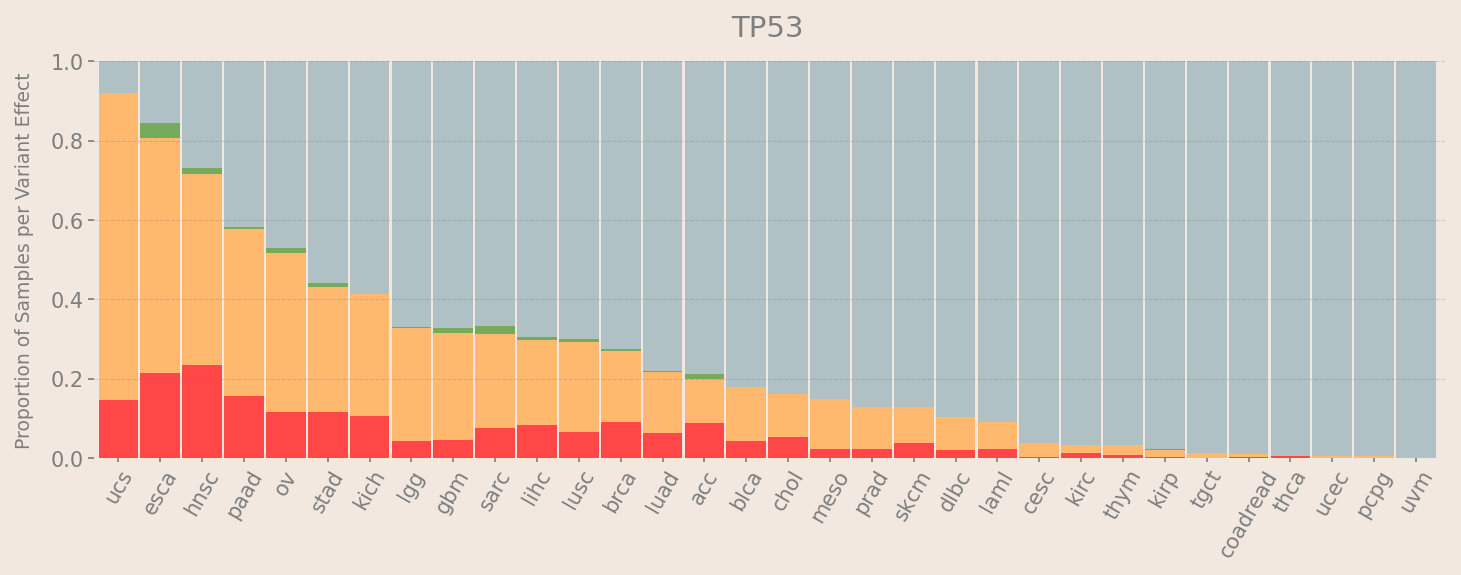

In [34]:
for gene in GenesOfInterest:
    fig, ax  = plt.subplots(figsize=(25/2.54, 10/2.54), dpi=150)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    df01 = data.loc[data.ApprovedSymbol == gene]; n=len(df01)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    count_df01 = df01.groupby(["ApprovedSymbol", "studyId", "impact"])["impact"].count().reset_index(name="IMPACT_count")
    pivot_df = count_df01.pivot(index='studyId', columns='impact', values='IMPACT_count').fillna(0)
    norm_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
    norm_df['Moderate_Severe_sum'] = norm_df['Moderate'] + norm_df['Severe']
    sorted_norm_df = norm_df.sort_values(by='Moderate_Severe_sum', ascending=False); print(sorted_norm_df.head())
    sorted_norm_df = sorted_norm_df.drop(columns='Moderate_Severe_sum')
    norm_df = sorted_norm_df[["Severe", "Moderate", "Mild", "No_impact"]].copy(); print(sorted_norm_df.head())

    norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#859da1', '#77ab5c', '#ffb96e', '#ff4747'])
    norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#ff4747', '#ffb96e', '#77ab5c', '#afc1c4'])
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    ax.set_title(gene, fontsize=14, color="#7E7E7E", pad=10)
    plt.xlabel("", fontsize=0); plt.ylabel("Proportion of Samples per Variant Effect", fontsize=9, color="#7E7E7E", labelpad=8)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -    
    ax.set_ylim(-.01, 1.01); ax.set_yscale('linear'); sns.despine(left=True, bottom=True)   
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -        
    plt.xticks(fontsize=10, color="#7E7E7E", rotation=60, ha="center")
    ax.tick_params(axis='x', which='major', direction='in', colors="#7E7E7E", pad=2, length=2)
    plt.yticks(fontsize=10, color="#7E7E7E", rotation=0, ha="center")
    ax.tick_params(axis='y', which='major', direction='in', colors="#7E7E7E", pad=10, length=3)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    kws_lines = {"ls":"--", 'color':'#7E7E7E', "alpha":0.3, "linewidth":.5}
    plt.axhline(y=0.2, **kws_lines); plt.axhline(y=0.4, **kws_lines);plt.axhline(y=0.6, **kws_lines);
    plt.axhline(y=0.8, **kws_lines); plt.axhline(y=1.0, **kws_lines);
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -   
    ax.set_facecolor('#f2e8df'); fig.patch.set_facecolor('#f2e8df')
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    plt.tight_layout(); #plt.show(); #plt.close()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:2],labels[0:2],fontsize=6,bbox_to_anchor=(1.02,1),loc=2,borderaxespad=0.1)
    plt.legend([],[],frameon=False)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -       
    #plt.savefig("tcga.png", format="png", bbox_inches="tight", dpi=300)

impact   Mild  Moderate  No_impact  Severe
studyId                                   
hnsc    0.017     0.482      0.268   0.233
esca    0.038     0.592      0.156   0.213
paad    0.006     0.422      0.417   0.156
ucs     0.000     0.774      0.081   0.145
stad    0.009     0.315      0.559   0.117


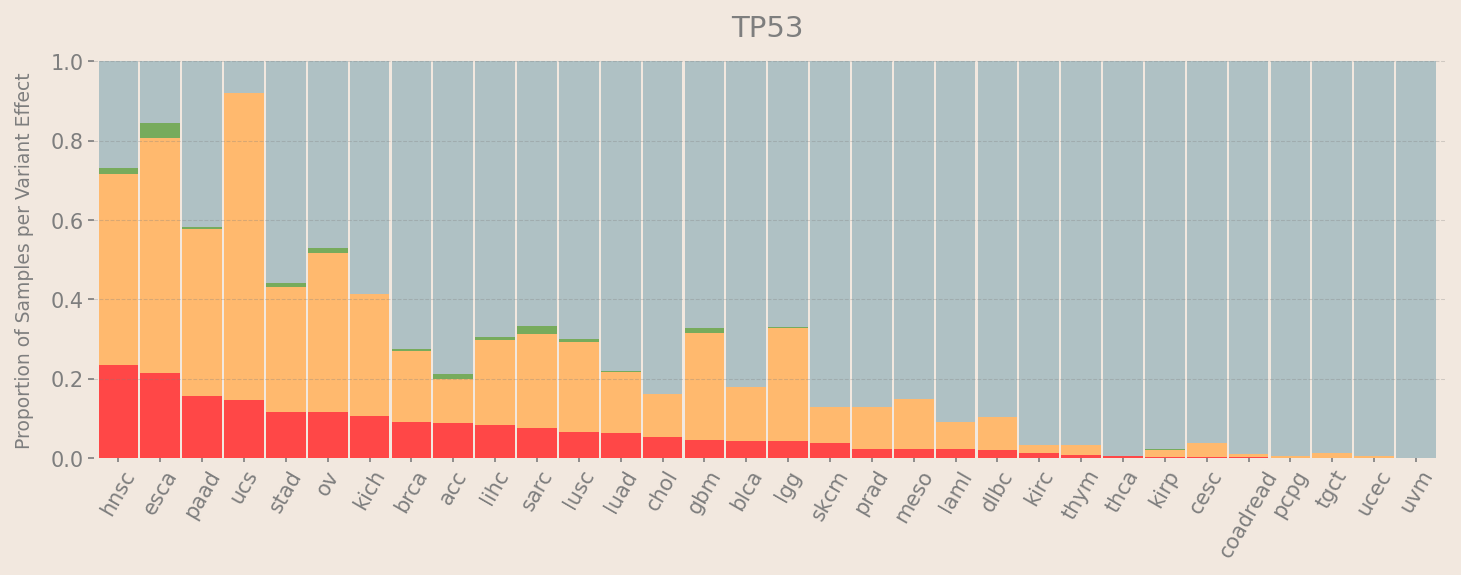

In [35]:
for gene in GenesOfInterest:
    fig, ax  = plt.subplots(figsize=(25/2.54, 10/2.54), dpi=150)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    df01 = data.loc[data.ApprovedSymbol == gene]; n=len(df01)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    count_df01 = df01.groupby(["ApprovedSymbol", "studyId", "impact"])["impact"].count().reset_index(name="IMPACT_count")
    pivot_df = count_df01.pivot(index='studyId', columns='impact', values='IMPACT_count').fillna(0)
    norm_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
    sorted_norm_df = norm_df.sort_values(by='Severe', ascending=False)
    norm_df = sorted_norm_df[["Severe", "Moderate", "Mild", "No_impact"]].copy(); print(sorted_norm_df.head())
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          - 
    norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#859da1', '#77ab5c', '#ffb96e', '#ff4747'])
    norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#ff4747', '#ffb96e', '#77ab5c', '#afc1c4'])
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    ax.set_title(gene, fontsize=14, color="#7E7E7E", pad=10)
    plt.xlabel("", fontsize=0); plt.ylabel("Proportion of Samples per Variant Effect", fontsize=9, color="#7E7E7E", labelpad=8)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -    
    ax.set_ylim(-.01, 1.01); ax.set_yscale('linear'); sns.despine(left=True, bottom=True)   
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -        
    plt.xticks(fontsize=10, color="#7E7E7E", rotation=60, ha="center")
    ax.tick_params(axis='x', which='major', direction='in', colors="#7E7E7E", pad=2, length=2)
    plt.yticks(fontsize=10, color="#7E7E7E", rotation=0, ha="center")
    ax.tick_params(axis='y', which='major', direction='in', colors="#7E7E7E", pad=10, length=3)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    kws_lines = {"ls":"--", 'color':'#7E7E7E', "alpha":0.3, "linewidth":.5}
    plt.axhline(y=0.2, **kws_lines); plt.axhline(y=0.4, **kws_lines);plt.axhline(y=0.6, **kws_lines);
    plt.axhline(y=0.8, **kws_lines); plt.axhline(y=1.0, **kws_lines);
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -   
    ax.set_facecolor('#f2e8df'); fig.patch.set_facecolor('#f2e8df')
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -  
    plt.tight_layout(); #plt.show(); #plt.close()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:2],labels[0:2],fontsize=6,bbox_to_anchor=(1.02,1),loc=2,borderaxespad=0.1)
    plt.legend([],[],frameon=False)
    #          -          -          -          -          -          -          -          -          -          -          -          -          -          -       
    #plt.savefig("tcga.png", format="png", bbox_inches="tight", dpi=300)

In [36]:
print("'cBioPortal_TCGA_GeneExprMutation.v01' script run time:", f'{time.time()-start:.0f}', "seconds.")

'cBioPortal_TCGA_GeneExprMutation.v01' script run time: 17 seconds.


In [37]:

count_df01 = df01.groupby(["ApprovedSymbol", "studyId", "impact"])["IMPACT_count"].sum().reset_index(name="IMPACT_count")
pivot_df = count_df01.pivot(index='studyId', columns='impact', values='IMPACT_count').fillna(0)
norm_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
norm_df['Moderate_Severe_sum'] = norm_df['Moderate'] + norm_df['Severe']
sorted_norm_df = norm_df.sort_values(by='Moderate_Severe_sum', ascending=False); print(sorted_norm_df.head())
sorted_norm_df = sorted_norm_df.drop(columns='Moderate_Severe_sum')
sorted_norm_df = sorted_norm_df[["Severe", "Moderate", "Mild", "No_impact"]].copy(); print(sorted_norm_df.head())

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
sorted_norm_df.plot(ax=ax, kind='bar', stacked=True, width=0.95, color=['#ff4747', '#ffb96e', '#77ab5c', '#859da1'])
plt.xlabel('Study ID')
plt.ylabel('Proportion of Impact Counts')
plt.title('Proportion of Impact Counts by Study ID (Ordered)')
plt.xticks(rotation=45)
plt.legend(title='Impact')
plt.show()


KeyError: 'Column not found: IMPACT_count'

# 